# REVEAL: Enhancing Visual-Language Models through Reasoning Verification





REVEAL is a high-quality, meticulously-crafted dataset designed for benchmarking and analyzing the manual and automatic verification of reasoning chains in visual-language models. This technique combines reasoning with task-specific actions and external knowledge, significantly improving decision-making processes. By grounding reasoning in real-world facts, REVEAL minimizes errors, reduces inaccuracies, and helps avoid hallucinations. The method offers clear, human-like task-solving steps, enhancing transparency and interpretability while achieving strong performance across tasks with fewer training examples.



## Key Features of REVEAL



- **Reasoning Chain Verification**: REVEAL provides a framework for evaluating the correctness of reasoning chains generated by models, ensuring that each step is logically sound and relevant.

- **Grounded Reasoning**: The methodology emphasizes grounding reasoning in real-world facts, which helps to minimize inaccuracies and enhances the reliability of outputs.

- **Human-like Task Solving**: By offering clear steps for task resolution, REVEAL improves the interpretability of model decisions, making it easier for users to understand the reasoning process.

- **Efficiency with Fewer Examples**: The approach allows models to perform well across various tasks even when trained on fewer examples, making them more efficient and adaptable.



## How REVEAL Works



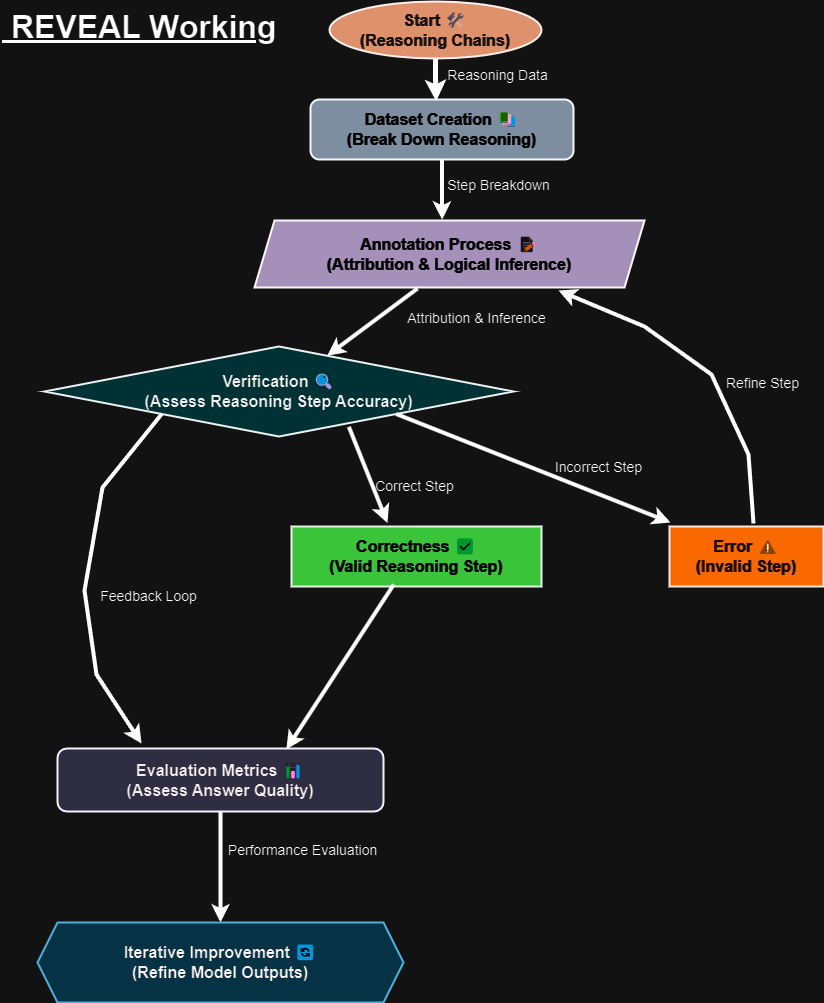

1. **Dataset Creation**: REVEAL is constructed by breaking down reasoning chains into individual steps and annotating each step based on its type (attribution or logical inference) and relevance.

2. **Annotation Process**:
   - Each step is evaluated for correctness based on whether it can be attributed to an evidence passage or logically inferred from previous steps.
   - For attribution steps, relevant Wikipedia paragraphs are retrieved to support claims made in the reasoning chain.

3. **Verification Mechanism**:
   - A verification framework assesses the correctness of each reasoning step, providing feedback that can be used to refine model outputs.
   - The framework distinguishes between logical correctness and attribution accuracy, highlighting areas where models may struggle.

4. **Evaluation Metrics**: Models are evaluated based on their ability to generate correct reasoning chains as well as their final answers, allowing for a comprehensive assessment of performance.

5. **Iterative Improvement**: Feedback from the verification process can be used to iteratively improve model training and enhance future performance on similar tasks.



In [ ]:
!pip install pypdf2 groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Step 1: Initialize the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 2: Download and process the PDF document
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 3: Define the query
query = "What is NLP?"
evaluation_dataset = [
    {"query": query, "expected_output": "Definition and applications of Natural Language Processing (NLP)"}
]

In [ ]:
# Step 4: Chunk the document for processing
chunks = [text[i:i + 1000] for i in range(0, len(text), 1000)]  # Divide document into manageable chunks
vectorizer = TfidfVectorizer()
chunk_embeddings = vectorizer.fit_transform(chunks)
query_embedding = vectorizer.transform([query])

In [ ]:
# Step 5: Retrieve relevant chunks using cosine similarity
similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()
top_k = 5  # Retrieve the top 5 most relevant chunks
retrieved_chunk_indices = similarities.argsort()[-top_k:][::-1]
retrieved_chunks = [chunks[i] for i in retrieved_chunk_indices]

In [ ]:
print(f"Top retrieved chunks for query '{query}':\n")
for idx, chunk in enumerate(retrieved_chunks, start=1):
    print(f"Chunk {idx}: {chunk[:200]}...\n")  # Display first 200 characters of each chunk

Top retrieved chunks for query 'What is NLP?':

Chunk 1: -art performance on a large suite
of sentence-level andtoken-level tasks, outper-
forming many task-speciﬁc architectures.
• BERT advances the state of the art for eleven
NLP tasks. The code and pre-t...

Chunk 2: RT is effective for both ﬁne-
tuning and feature-based approaches.
6 Conclusion
Recent empirical improvements due to transfer
learning with language models have demonstrated
that rich, unsupervised pr...

Chunk 3: ft representations.
When integrating contextual word embeddings
with existing task-speciﬁc architectures, ELMo
advances the state of the art for several major NLP
benchmarks (Peters et al., 2018a) inc...

Chunk 4: . At the in-
put, sentence Aand sentence Bfrom pre-training
are analogous to (1) sentence pairs in paraphras-
ing, (2) hypothesis-premise pairs in entailment, (3)
question-passage pairs in question an...

Chunk 5: or2tensor library.1Because the use
of Transformers has become common and our im-
plemen

In [ ]:
# Step 6: REVEAL Process - Prepending retrieved information to the original query and passing it to Groq
module_results = []
for chunk in retrieved_chunks:
    try:
        # Combine query with relevant chunk to form reasoning chains
        combined_input = f"Query: {query}\nRelevant information: {chunk}"

        # Send the combined input to the Groq API for generating the final answer
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a highly knowledgeable assistant."},
                {"role": "user", "content": combined_input},
            ],
            model="llama3-8b-8192",  # Model selection
        )

        answer = response.choices[0].message.content
        module_results.append({"chunk": chunk[:200], "answer": answer})  # Store chunk and answer
        print(f"Generated answer: {answer}")

    except Exception as e:
        print(f"Error generating answer: {e}")

Generated answer: NLP stands for Natural Language Processing. It is a subfield of artificial intelligence (AI) that deals with the interaction between computers and humans in natural language. NLP is concerned with the development of algorithms and statistical models that enable computers to process, understand, and generate natural language data.

The passage you provided discusses NLP and its relationship to pre-trained language models, specifically BERT (Bidirectional Encoder Representations from Transformers). BERT is a type of pre-trained language model that has achieved state-of-the-art performance on many NLP tasks, outperforming many task-specific architectures.

The passage also mentions other related work in the field of pre-training general language representations. This includes unsupervised feature-based approaches, such as non-neural and neural methods, as well as the use of pre-trained word embeddings.

In general, NLP has many applications, including:

1. Sentiment anal

In [ ]:
# Step 7: Find the best result
best_result = max(module_results, key=lambda x: len(x["answer"]))  # Select result with the longest answer
print("\nBest result based on module evaluation:")
print(f"Chunk: {best_result['chunk']}\nAnswer: {best_result['answer']}")


Best result based on module evaluation:
Chunk: ft representations.
When integrating contextual word embeddings
with existing task-speciﬁc architectures, ELMo
advances the state of the art for several major NLP
benchmarks (Peters et al., 2018a) inc
Answer: NLP stands for Natural Language Processing, which is a field of study focused on the interaction between computers and humans in natural language. NLP deals with the interactions between computers and humans in natural languages, such as speech, text, gesture, or other forms of communication.

Natural Language Processing involves the development of algorithms and statistical models that enable computers to process, understand, and generate human language. This includes tasks such as:

1. Language Modeling: Predicting the next word in a sentence or text.
2. Sentiment Analysis: Identifying the sentiment or emotion conveyed in a text.
3. Named Entity Recognition: Identifying named entities such as people, places, and organizations.
4. T

## Initialize the Client
The Groq client is set up to handle requests for generating responses based on reasoning.

## Document Download and Processing
A PDF document (BERT paper) is downloaded from the specified URL. The document is read and converted into plain text for analysis.

## Query Definition
The query "What is NLP?" is defined to focus on extracting relevant information about Natural Language Processing.

## Document Chunking
The document is divided into smaller, manageable chunks (e.g., 1000 characters each) to ensure efficient processing. TF-IDF (Term Frequency-Inverse Document Frequency) is used to create embeddings for each chunk, representing their importance in the document.

## Query and Chunk Matching
The query is embedded using the same TF-IDF vectorizer. Cosine similarity is computed between the query embedding and chunk embeddings to identify the top 5 most relevant chunks from the document.

## REVEAL Framework Implementation
- **Reasoning Chains**: Each retrieved chunk is combined with the query to create reasoning chains that break down the problem into smaller, logical steps.
- **Attribution**: Relevant information is annotated to ensure it is supported by evidence (chunks from the document).
- **Verification**: The combined query and chunk are sent to the Groq API, which verifies the correctness of the reasoning and generates a response.

## Iterative Refinement
Multiple responses are generated by iterating over the top chunks. Feedback from Groq ensures the reasoning and answers are refined to improve accuracy.

## Result Selection
The generated answers are evaluated, and the best result is selected based on the length or relevance of the response.

## Output
The system outputs the top relevant chunks and the final selected response, showcasing how NLP is defined and applied.


## Applications of REVEAL



- **Model Benchmarking**: Provides a robust framework for evaluating the performance of visual-language models in generating accurate and reliable reasoning chains.

- **Research Development**: Assists researchers in understanding the limitations of current models and identifying areas for improvement in reasoning capabilities.

- **Educational Tools**: Enhances educational applications by ensuring that generated content is factually accurate and logically sound.

- **Content Generation Systems**: Supports content creation tools by providing a mechanism for verifying the accuracy and coherence of generated narratives or explanations.



## Advantages of REVEAL



- **Improved Accuracy**: By focusing on verifying reasoning chains, REVEAL enhances the overall accuracy of model outputs, reducing the likelihood of errors.

- **Enhanced Interpretability**: The clear task-solving steps provided by REVEAL improve transparency in how models arrive at their conclusions, fostering user trust.

- **Adaptability**: The ability to achieve strong performance with fewer training examples makes REVEAL particularly useful in scenarios where data is limited or costly to obtain.

- **Robustness Against Hallucinations**: By grounding reasoning in factual information, REVEAL helps mitigate the risk of generating hallucinated content.



## Limitations of REVEAL



- **Dependence on Quality Annotations**: The effectiveness of REVEAL relies heavily on the quality of the annotations used for verifying reasoning chains; poor annotations can lead to misleading evaluations.

- **Complexity in Implementation**: Integrating verification mechanisms into existing models may introduce complexity and require significant adjustments to model architectures.

- **Limited Scope**: While REVEAL focuses on reasoning verification, it may not address all aspects of model performance across diverse tasks comprehensively.



## Conclusion



REVEAL represents a significant advancement in verifying reasoning chains within visual-language models. By combining rigorous verification processes with grounded reasoning techniques, it enhances both accuracy and interpretability in model outputs. As AI continues to evolve, frameworks like REVEAL will play a crucial role in ensuring that language models produce reliable and trustworthy information.



Having explored REVEAL, we will now move on to REACT.